# FMRI Analysis 

# First Levels

## Make Task Paradigm Files 

Here I make regressors for the congruent and incongruent conditions. I make both full duration boxcar regressors and variable rt epoch regressors to look at RT independent and dependent effects. Methods and considerations based on the following papers:

- Tal Yarkoni's Blog Post on time on task implications: https://www.talyarkoni.org/blog/2010/06/16/time-on-task-effects-in-fmri-research-why-you-should-care/
- Yarkoni paper related to above blog post: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2622763/
- Grinbad Paper explaining variable RT epoch method as most ideal method for accounting for time on task effects: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2654219/

Note that the variable RT epoch model assumes the process is well approximated by a diffusion model.

In [1]:
import sys
sys.path.append('../src')
from utils import select_subjects
import pandas as pd

# load and clean behavior
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                       sep='\t', na_values='n/a')
behavior = behavior[behavior.modality == 'fmri']
exclusions = ['error', 'post_error', 'no_response', 'fast_rt']
behavior = behavior[behavior[exclusions].sum(axis=1) == 0]

# output directory
fsfast_path = '../data/derivatives/fsfast'

subjects = select_subjects('both')
for subject in subjects:
    
    sub_behavior = behavior[behavior.participant_id == subject]
    sub_behavior['tt'] = sub_behavior.trial_type.astype('category').cat.codes + 1
    sub_behavior['weight'] = 1.0
    
    # extract behavior information
    for typ in ['base', 'rt']:
        if typ == 'base':
            columns = ['onset', 'tt', 'duration', 'weight', 'trial_type']
        else:
            columns = ['onset', 'tt', 'response_time', 'weight', 'trial_type']
        
        df = sub_behavior[columns]
        
        # save the regressors
        f = '%s/%s/msit/001/%s.par'
        df.to_csv(f % (fsfast_path, subject, typ), header=False, sep='\t',
                  index=False)
        
        
print('Done!') 

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!


## Make Motion Timepoint Censors

We use only functional displacement based motion timepoint censoring (and no motion regressors) as determined in <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3895106/"> Siegel 2013 </a>. We use their threshold of 0.9 mm though we recognize this was not a global recommendation, but it is used here as a reasonable value without further investigation.

In [2]:
import sys
sys.path.append('../src')
from utils import select_subjects
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fd = 0.9

# paths
fmriprep_path = '../data/derivatives/fmriprep'
fsfast_path = '../data/derivatives/fsfast'

subjects = select_subjects('both')
fds = []
for i, subject in enumerate(subjects):
    
    f = '%s/%s/func/%s_task-msit_bold_confounds.tsv'
    confounds = pd.read_csv(f % (fmriprep_path, subject, subject),
                            sep='\t', na_values='n/a')
    
    # determine fd censor indices 
    fd_ix = np.array(confounds.FramewiseDisplacement >= fd).astype(int)
    fds.append(fd_ix)
    
    # save censor indices
    f = '%s/%s/msit/001/fd_censor.par' 
    np.savetxt(f % (fsfast_path, subject), fd_ix, fmt='%d')
        
# Plot censor heatmap
fds = np.array(fds)
plt.figure(figsize=(14, 10))
sns.heatmap(fds, cbar=False)
plt.xticks(())
plt.yticks(np.arange(len(subjects)) + .5, subjects, rotation=0)
plt.xlabel('TR')
plt.ylabel('Subject')
plt.show()

## Run 1st Levels

### Set up the analysis

In [3]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fsfast
cd $FSFAST

# set up the analyses
types="base rt"
hemis="lh rh"
fwhm=4

for type in $types
do
    for hemi in $hemis 
    do
        mkanalysis-sess -analysis $type.$hemi \
                        -surface fsaverage $hemi \
                        -event-related \
                        -fsd msit \
                        -fwhm $fwhm \
                        -per-run \
                        -TR 1.75 \
                        -refeventdur 1.75 \
                        -paradigm $type.par \
                        -nconditions 2 \
                        -spmhrf 0 \
                        -polyfit 0 \
                        -hpf 0.01 \
                        -nskip 4 \
                        -tpexclude fd_censor.par \
                        -no-mask \
                        -force
    done
    
    mkanalysis-sess -analysis $type.mni305 \
                    -mni305 \
                    -event-related \
                    -fsd msit \
                    -fwhm $fwhm \
                    -per-run \
                    -TR 1.75 \
                    -refeventdur 1.75 \
                    -paradigm $type.par \
                    -nconditions 2 \
                    -spmhrf 0 \
                    -polyfit 0 \
                    -hpf 0.01 \
                    -nskip 4 \
                    -tpexclude fd_censor.par \
                    -force
done

Setting TER to 0.050000
Setting TimeWindow to 40.000000
Setting PreStim    to 0
Setting PostStim   to 40.000000
# FSBUILD freesurfer-Linux-centos6_x86_64-stable-pub-v6.0.0-2beb96c
# MKAVERSION $Id: mkanalysis-sess,v 1.78 2015/12/10 22:51:30 zkaufman Exp $
# MKACMD /usr/local/freesurfer/stable6_0_0/fsfast/bin/mkanalysis-sess -analysis base.lh -surface fsaverage lh -event-related -fsd msit -fwhm 4 -per-run -TR 1.75 -refeventdur 1.75 -paradigm base.par -nconditions 2 -spmhrf 0 -polyfit 0 -hpf 0.01 -nskip 4 -tpexclude fd_censor.par -no-mask -force
# DATE Mon May 14 11:06:55 EDT 2018

analysis base.lh
mcstem fmcpr
fsd msit
TR 1.75
RegDOF 6
PerSession 0
RawSpace surface fsaverage lh
mask nomask
RawFWHM 4
RawSTC none
nSliceGroups 1
UseB0DC 0
ApplySubCortMask 1
inorm 100
acfbins 30
fixacf  1
acffwhm 20
acfsvd  0
designtype event-related
tpexclude fd_censor.par
nskip 4
polyfit 0
HPFCutoffHz 0.01
HeteroGCor 0
nconditions 2
parname base.par
RefEventDur 1.75
timewindow 40.000000
prestim 0
TER 0.05

### Compute Contrast Matrices

In [4]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fsfast
cd $FSFAST

types="base rt"
spaces="lh rh mni305"

for type in $types
do
    for space in $spaces
    do
        mkcontrast-sess -analysis $type.$space \
                        -contrast incongruent \
                        -a 2
                        
        mkcontrast-sess -analysis $type.$space \
                        -contrast congruent \
                        -a 1
                        
        mkcontrast-sess -analysis $type.$space\
                        -contrast incongruent-congruent \
                        -a 2 -c 1
                        
    done
    
done

INFO: Found 2 Non-Null Conditions
INFO: Found 1 Delays
Condition Weights: 0 1.00000000000000000000
mkcontrast2 -config base.lh/incongruent.config -anadir base.lh -wcond 0 1.00000000000000000000 -sumconds -o base.lh/incongruent.mat -wdelay 1 -no-octave
  $Id: mkcontrast2,v 1.3 2016/03/11 23:46:48 greve Exp $
cmtxfile  base.lh/incongruent.mat
nconds    2,  wcond  0 1.00000000000000000000
ndelays   1, wdelay 1
ndelays   1, wpsa   
sumconds  1
sumdelays 0
nircorr   0
TER       0.050000
rdelta    
rtau      
  cmtxfile  base.lh/incongruent.mat
  monly  0
  NCond   2
  WCond   0 1.00000000000000000000
  NDelay  1
  WDelay  1
  TER         0.050000
  sumconds   1
  sumdelays  0
  nircorr  0
  TPreStim  0
  RmPreStim  0
  rdelta     0 0
  rtau       0 0
  ndelays    1
  CNorm      1
  setwdelay  0
  setwcond   0
Matlab file is /tmp/mkcontrast2.70469.m
MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2017 The MathWo

### Fit the GLMs

In [5]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fsfast
cd $FSFAST

# set up the analyses
types="base rt"
spaces="lh rh mni305"

for type in $types
do
    for space in $spaces
    do
        selxavg3-sess -analysis $type.$space -sf subjects -no-preproc \
                      -overwrite
    done
    
done

Surface data fsaverage lh
--------------------------------------------------------------
selxavg3-sess logfile is /autofs/space/cassia_001/users/matt/msit/data/derivatives/fsfast/log/selxavg3-sess-msit-base.lh-180514111922.log
--------------------------------------------------------------
selxavg3-sess log file
/usr/local/freesurfer/stable6_0_0/fsfast/bin/selxavg3-sess
-analysis base.lh -sf subjects -no-preproc -overwrite
$Id: selxavg3-sess,v 1.68 2016/05/10 03:24:18 greve Exp $
uid=3950117(mwb27) gid=3950117(mwb27) groups=3950117(mwb27),973(docker),1047(iliad)
/autofs/space/cassia_001/users/matt/msit/data/derivatives/fsfast
Linux cassia.nmr.mgh.harvard.edu 3.10.0-693.11.1.el7.x86_64 #1 SMP Mon Dec 4 23:52:40 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
Mon May 14 11:19:22 EDT 2018
-------------------------------------------
1/50 /autofs/space/cassia_001/users/matt/msit/data/derivatives/fsfast/sub-hc001 
Mon May 14 11:19:23 EDT 2018
anadir = /autofs/space/cassia_001/users/matt/msit/data/der

### Visualize the Design Matrices

In [6]:
import sys
sys.path.append('../src')
from utils import select_subjects
from fmri import plot_design_matrix
import matplotlib.pyplot as plt

fsfast_path = '../data/derivatives/fsfast'

subjects = select_subjects('both')
for subject in subjects:

    for typ in ['base', 'rt']:
        
        fig = plot_design_matrix(fsfast_path, subject, typ)
        f = '%s/%s/msit/%s_design_matrix.png'
        fig.savefig(f % (fsfast_path, subject, typ))
        plt.close(fig)
        
print('Done!')

Done!


## Visualize 1st Level Results

In [2]:
from surfer import Brain
import sys
sys.path.append('../src')
from utils import select_subjects

fsfast_path = '../data/derivatives/fsfast'
SUBJECTS_DIR = '/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer'

subjects = select_subjects('both')
for subject in subjects:

    for typ in ['base', 'rt']:
        
        # plot sig
        brain = Brain('fsaverage', 'split', 'inflated', views=['lat', 'med'],
                      subjects_dir=SUBJECTS_DIR)
        
        for hemi in ['lh', 'rh']:
            f = '%s/%s/msit/%s.%s/incongruent-congruent/sig.nii.gz' % (fsfast_path, subject,
                                                 typ, hemi)
            brain.add_overlay(f, hemi=hemi, min=1.3, max=5)
        f = '%s/%s/msit/%s_sig.png' % (fsfast_path, subject, typ) 
        brain.save_image(f)

print('Done!')

Exception occurred in traits notification handler for object: <mayavi.tools.filters.ThresholdFactory object at 0x7f4bd8dced70>, trait: low, old value: None, new value: 1.3
Traceback (most recent call last):
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/traits/trait_notifiers.py", line 340, in __call__
    self.handler( *args )
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/mayavi/tools/filters.py", line 79, in _low_changed
    self._target.lower_threshold = self.low
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/traits/trait_types.py", line 1866, in _set
    self.error( object, name, value )
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/traits/trait_handlers.py", line 172, in error
    value )
TraitError: The 'lower_threshold' trait of a Threshold instance must be

Exception occurred in traits notification handler.
Please check the log file for details.
Done!


# Group Levels

## Collect Data & Compute Connectivity

In [18]:
import sys
sys.path.append('../src')
from utils import select_subjects
import numpy as np
import nibabel as nib
import os
import pandas as pd
from scipy.sparse import coo_matrix
from mne import read_surface, spatial_tris_connectivity

deriv_dir = '../data/derivatives/fmri_group_levels'
if not os.path.exists(deriv_dir):
    os.makedirs(deriv_dir)

np.random.seed(10)
num_perm = 5000

subjects = select_subjects('both')
fsfast_dir = '../data/derivatives/fsfast'
subjects_dir = '../data/derivatives/freesurfer'

# create scanner type nuisance regressors
demo = pd.read_csv('../data/participants.tsv', sep='\t', na_values='n/a')
demo = demo[demo.participant_id.isin(subjects)]
sc = demo.scanner.astype('category').cat.codes
Z = np.array(pd.get_dummies(sc))[:, 1:]

typs = ['base', 'rt']
spaces = ['lh', 'rh', 'mni305']

# compute the subcortical mask
roi_dict = {18:'Left-Amygdala', 11:'Left-Caudate', 17:'Left-Hippocampus', 
            12:'Left-Putamen', 54:'Right-Amygdala', 50:'Right-Caudate', 
            53:'Right-Hippocampus', 51:'Right-Putamen'}
aseg = '%s/fsaverage/mri.2mm/aseg.mgz' % subjects_dir
aseg = nib.load(aseg).get_data()
subcort_mask = np.in1d(aseg, roi_dict.keys()).reshape(aseg.shape)
voxels = np.vstack(np.where(subcort_mask)).T

for typ in typs:
    print(typ)
    
    for space in spaces:
        print(space)
        
        # compute connectivity
        if space == 'mni305':
            n_voxels = voxels.shape[0]
            coo = np.zeros([n_voxels,n_voxels], dtype=int)
            # 6-lattice connectivity (up,down,forward,backward,left,right)
            for n in range(n_voxels):
                diff = np.linalg.norm(voxels - voxels[n], axis=1)
                M, = np.where(diff == 1.)
                for m in M: 
                    coo[n, m] = 1 
            coo = coo_matrix(coo)
        else:
            f = '%s/fsaverage/surf/%s.white' % (subjects_dir, space)
            _, tris = read_surface(f)
            coo = spatial_tris_connectivity(tris, remap_vertices=True)
        
        # load data + weights
        Ws = []
        Ys = []
        for subject in subjects:
            analysis_folder = '%s/%s/msit/%s.%s/incongruent-congruent'
            analysis_folder = analysis_folder % (fsfast_dir, subject,
                                                 typ, space)
            
            f = '%s/ces.nii.gz' % analysis_folder
            Ys.append(nib.load(f).get_data())
            
            f = '%s/cesvar.nii.gz' % analysis_folder
            Ws.append(nib.load(f).get_data())
        
        # extract weights
        # 1 / variance
        W = np.array(Ws).squeeze()
        W = np.abs(1 / W)
        
        Y = np.array(Ys).squeeze()
        
        # 1d the subcortical data and reduce to rois
        if space == 'mni305':
            W = W[:, subcort_mask]
            Y = Y[:, subcort_mask]
        
        # we only include voxels that had non-zero variance for every subject
        include = ~np.isinf(W).sum(axis=0).astype(bool)
        
        # compute sign flips 
        sign_flips = np.random.choice([1, -1], size=(num_perm, Y.shape[0]),
                                      replace=True)
        
        # save out
        np.savez_compressed('%s/%s_%s_data.npz' % (deriv_dir, typ, space),
                            Y=Y, W=W, Z=Z, sign_flips=sign_flips,
                            include=include, conn=coo.data, col=coo.col,
                            shape=coo.shape, row=coo.row, 
                            subcort_mask=subcort_mask, voxel_ix=voxels)
print('Done!') 

base
lh


/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in divide


rh
mni305
rt
lh
rh
mni305
Done!


## Compute TFCE Permutation P-Values

In [1]:
import sys
sys.path.append('../src')
import nibabel as nib
import os
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import pandas as pd
from mne.stats.cluster_level import _find_clusters
import statsmodels.api as sm
from mne import read_surface, spatial_tris_connectivity, set_log_level
from joblib import Parallel, delayed
from scipy.sparse import coo_matrix

set_log_level('critical')

# credit Sam
def wls(X,Y,W):
    B = np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(Y)
    ssr = W.dot( np.power(Y - np.dot(X,B),2) ).sum()
    scale = ssr / (Y.shape[0] - X.shape[1])
    cov_p = np.linalg.inv(X.T.dot(W).dot(X)) * scale
    F = np.power(B[0],2) * np.power(cov_p[0,0],-1)
    return B[0], F

def perm_tfce_glm(i):
    print(i)
    
    sf = sign_flips[i, :]
    # permute and wls the data
    fs = []
    for j in range(Y.shape[1]):
        if include[j]:
            Z = X[:, 1:]
            w = np.diag(W[:, j])
            y = Y[:, j][:, np.newaxis]
            ZZ = Z.dot(np.linalg.inv(Z.T.dot(w).dot(Z))).dot(Z.T).dot(w)
            Rz = np.identity(Y.shape[0]) - ZZ
            y_perm = np.diag(sf).dot(Rz).dot(y)
            beta, f = wls(X, y_perm, w)
            fs.append(f[0])
            
#             w = W[:, j]
#             z = X[:, 1:]
#             y = Y[:, j][:, np.newaxis]
#             tmp = np.linalg.inv(z.T.dot(np.diag(w)).dot(z))
#             zb = tmp.dot(z.T).dot(np.diag(w)).dot(y)
#             res = y - z.dot(zb)
#             yperm = sf * res + z.dot(zb)
#             wls = sm.WLS(yperm, X, w)
#             result = wls.fit()
#             t.append(result.tvalues[0])
        else:
            fs.append(0)
    fs = np.array(fs)
    
    # compute tfce
    _, tfce = _find_clusters(fs, threshold, tail=0, 
                             connectivity=coo, include=include,
                             max_step=1, show_info=False)
    
    return np.max(np.abs(tfce))
    

deriv_dir = '../data/derivatives/fmri_group_levels'
subjects_dir = '../data/derivatives/freesurfer/fsaverage'
np.random.seed(10)
threshold = dict(start=0.1, step=0.1, h_power=2, e_power=0.5)

typs = ['base', 'rt']
spaces = ['mni305', 'lh', 'rh']

for typ in typs:
    print(typ)
    
    for space in spaces:
        print(space)
        
        
        # extract data
        data = np.load('%s/%s_%s_data.npz' % (deriv_dir, typ, space))
        Z = data['Z']
        X = np.hstack((np.ones((Z.shape[0], 1)), Z))
        W = data['W']
        Y = data['Y']
        sign_flips = data['sign_flips']
        include = data['include']
        num_perm = sign_flips.shape[0]
        num_perm = 1000
        
        # extract connectivity 
        coo = coo_matrix((data['conn'], (data['row'], data['col'])),
                          data['shape'])
            
        # compute the base statistic + tfce
        betas = []
        fs = []
        for i in range(Y.shape[1]):
            if include[i]:
                beta, f = wls(X, Y[:, i][:, np.newaxis],
                              np.diag(W[:, i]))
#                 wls = sm.WLS(Y[:, i], X, W[:, i])
#                 result = wls.fit()
#                 beta.append(result.params[0])
#                 t.append(result.tvalues[0])
                fs.append(f[0])
                betas.append(beta[0])
            else:
                fs.append(0)
                betas.append(0)
        betas = np.array(betas)
        fs = np.array(fs)
            
        _, tfce = _find_clusters(fs, threshold, tail=0, 
                                 connectivity=coo, include=include,
                                 max_step=1, show_info=False)
        
        perm_dist = Parallel(n_jobs=10)(delayed(perm_tfce_glm)(i) 
                                       for i in range(num_perm))
        perm_dist = np.array(perm_dist)
        
        tmp = np.tile(perm_dist[:, np.newaxis], (1, tfce.shape[0])) 
        p = (np.sum(np.abs(tmp) >= np.abs(tfce), axis=0) + 1.) / (num_perm + 1.)
        
        np.savez_compressed('%s/%s_%s_stats.npz' % (deriv_dir, typ, space),
                            pvals=p, perm_dist=perm_dist, beta=betas,
                            fmap=fs, tfce=tfce, include=include)
        
print('Done!')

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


rt
lh
0
1
3
5
6
2
4
8
9
7
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


## Find Clusters & Save Maps

In [2]:
import nibabel as nib
import numpy as np
from mne.stats.cluster_level import _find_clusters as find_clusters
from mne import read_surface, spatial_tris_connectivity 
from scipy.sparse import coo_matrix

deriv_dir = '../data/derivatives/fmri_group_levels'
fsfast_dir = '../data/derivatives/fsfast'
subjects_dir = '../data/derivatives/freesurfer'
np.random.seed(10)
threshold = dict(start=0.1, step=0.1, h_power=2, e_power=0.5)

typs = ['base', 'rt']
spaces = ['mni305', 'lh', 'rh']

for typ in typs:
    print(typ)
    
    for space in spaces:
        print(space)
        
        stats = np.load('%s/%s_%s_stats.npz' % (deriv_dir, typ, space))
        stats = {'pvals': stats['pvals'],
                 'tfce': stats['tfce'],
                 'beta': stats['beta'],
                 'include': stats['include'],
                 'perm_dist': stats['perm_dist']}
        stats['pvals'] = -np.log10(stats['pvals']) * np.sign(stats['beta'])
        stats['tfce'] = stats['tfce'] * np.sign(stats['beta'])
        
        # load connectivity
        data = np.load('%s/%s_%s_data.npz' % (deriv_dir, typ, space))
        coo = coo_matrix((data['conn'], (data['row'], data['col'])),
                         data['shape'])
        
        # extract clusters
        threshold = -np.log10(0.05)
        clusters, sums = find_clusters(stats['pvals'].squeeze(), threshold, 
                                       tail=0, connectivity=coo, 
                                       include=stats['include'],
                                       t_power=0)
        
        # compute mm cluster size for cortical surface
        if space != 'mni305':
            f = '%s/fsaverage/surf/%s.white.avg.area.mgh'
            avg_area = nib.load(f % (subjects_dir, space)).get_data().squeeze()
            sums = np.array([avg_area[c].sum() for c in clusters])
        
        
        # threshold clusters by size
        stats['mask'] = np.zeros_like(stats['pvals'])
        min_cluster = {'lh': 100, 'rh': 100, 'mni305': 1}
        good_ix = []
        new_clusters = []
        new_sums = []
        for c, s in zip(clusters, sums):
            if s > min_cluster[space]:
                new_clusters.append(c)
                new_sums.append(s)
                good_ix.append(c)
        print('%d clusters found' % len(good_ix))
        if len(good_ix) > 0:
            good_ix = np.concatenate(good_ix)
            stats['mask'][good_ix] = 1
        
        
        # reshape and save maps
        for mapp in ['pvals', 'beta', 'tfce', 'mask']:
            print(mapp)
            print(stats[mapp])
            if space == 'mni305':
                aseg = '%s/fsaverage/mri.2mm/aseg.mgz' % subjects_dir
                aseg = nib.load(aseg)
                affine = aseg.affine
                voxel_ix = data['voxel_ix']
                mapp_data = np.zeros(aseg.get_data().shape)
                x, y, z = voxel_ix[:, 0], voxel_ix[:, 1], voxel_ix[:, 2]
                mapp_data[x, y, z] += stats[mapp].astype(float)
            else:
                f = '%s/sub-hc005/msit/%s.%s/incongruent-congruent/ces.nii.gz'
                holder = nib.load(f % (fsfast_dir, typ, space))
                affine = holder.affine
                mapp_data = stats[mapp].astype(float)
                
            # extend to full range
            for i in range(4 - len(mapp_data.shape)):
                mapp_data = np.expand_dims(mapp_data, -1)
                
            img = nib.Nifti1Image(mapp_data, affine)
            nib.save(img, '%s/%s_%s_%s.nii' % (deriv_dir, typ, space, mapp))
        
        # save out clusters + cluster mask
        np.savez_compressed('%s/%s_%s_clusters.npz' % (deriv_dir, typ, space),
                            clusters=new_clusters, sums=new_sums,
                            cluster_ix=good_ix)
        
print('Done!') 

base
mni305
0 clusters found
pvals
[-0. -0.  0. ..., -0. -0. -0.]
beta
[ 0.04875581  0.00418175 -0.01701581 ...,  0.01365661  0.00379701
  0.00145946]
tfce
[ 1.28854989  0.         -1.41728459 ...,  1.10927713  0.          0.        ]
mask
[ 0.  0.  0. ...,  0.  0.  0.]
lh
1 clusters found
pvals
[ 2.15533604  3.00043408  0.         ...,  0.          0.         -0.        ]
beta
[ 0.12464842  0.1942049  -0.00365648 ..., -0.01962812 -0.00925028
  0.00313894]
tfce
[ 262.72740218  635.16768732   -0.         ...,   -4.54437928   -0.            0.        ]
mask
[ 1.  1.  0. ...,  0.  0.  0.]
rh
5 clusters found
pvals
[ 1.38765022  3.00043408  0.         ..., -0.         -0.         -0.        ]
beta
[ 0.07536194  0.16834958 -0.01928524 ...,  0.00600369  0.00808289
  0.01233599]
tfce
[ 133.88065429  479.92868045   -7.62256022 ...,    3.64481824    3.64481824
    9.79936677]
mask
[ 1.  1.  0. ...,  0.  0.  0.]
rt
mni305
0 clusters found
pvals
[-0.  0.  0. ..., -0.  0.  0.]
beta
[ 0.06208592 -0

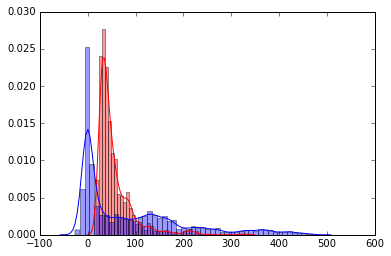

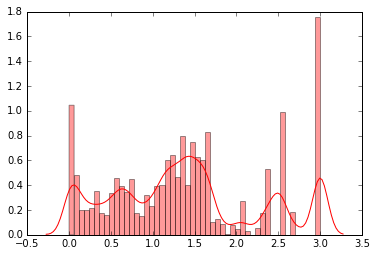

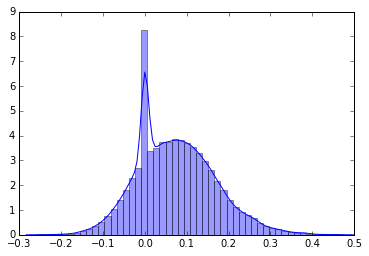

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(stats['perm_dist'], color='r')
sns.distplot(stats['tfce'], color='b')
plt.show()

sns.distplot(stats['pvals'][stats['pvals'] > 0], color='r')
plt.show()
sns.distplot(stats['beta'], color='b')
plt.show()

## Visualize

In [10]:
from surfer import Brain
subjects_dir = '../data/derivatives/freesurfer'
deriv_dir = '../data/derivatives/fmri_group_levels'

# base or rt
typ = 'rt'
# lh or rh
space = 'lh'
# inflated, white, or pial
surf = 'inflated'
# beta, pvals, or tfce
mapp = 'pvals'

brain = Brain('fsaverage', space, surf, subjects_dir=subjects_dir,
              views=['lat', 'med'])

overlay = '%s/%s_%s_%s.nii' % (deriv_dir, typ, space, mapp)
p_thres = -np.log10(.05)
brain.add_overlay(overlay, min=p_thres, max=p_thres * 3)

brain.save_image('%s/%s_%s_%s.png' % (deriv_dir, typ, space, mapp))


In [12]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

typ=rt
map=pvals

cd ../data/derivatives/fmri_group_levels

tkmeditfv fsaverage orig.mgz -aseg -overlay ${typ}_mni305_${map}.nii -overlay ${typ}_mni305_mask.nii

Process is interrupted.
